In [1]:
import random
import numpy as np
from numpy.linalg import norm as vector_norm
import matplotlib.pyplot as plt
from itertools import product

import sys
sys.path.append('../modules')
from nsw.nsw_classifier import NSWClassifier
from nsw import rbf

In [2]:
from itertools import product

def plot_potential(mn, mx, f, eps, width=51):
    xi = yi = np.linspace(mn, mx, width)
    pairs = np.array(list(product(xi, yi)))
    test = f(pairs[0], eps)
    print(type(test))
    if type(test) == float or type(test) == np.float64 or type(test) == int:
        print('flat')
        zi = np.array([f(pair, eps) for pair in pairs]).reshape((width, -1))
        mnv, mxv = zi.min(), zi.max()
        mnv, mxv = -max(abs(mnv), abs(mxv)), max(abs(mnv), abs(mxv))
        fig, ax = plt.subplots(figsize=(15, 15))
        c = ax.pcolormesh(xi, yi, zi, cmap='RdBu', vmin=mnv, vmax=mxv)
        ax.set_title('class edge')
        # set the limits of the plot to the limits of the data
        ax.axis([xi.min(), xi.max(), yi.min(), yi.max()])
        fig.colorbar(c, ax=ax)
        plt.show()
    else:
        print('field')
        zi = np.array([f(pair, eps) for pair in pairs]).reshape((-1, 2))
        fig, ax = plt.subplots(figsize=(15, 15))
        c = ax.quiver(pairs[:, 0], pairs[:, 1], zi[:,0], zi[:, 1], width=.0008)
        ax.set_title('class edge')
        # set the limits of the plot to the limits of the data
        ax.axis([xi.min(), xi.max(), yi.min(), yi.max()])
        plt.show()

Classifier graph is build in 25.851s


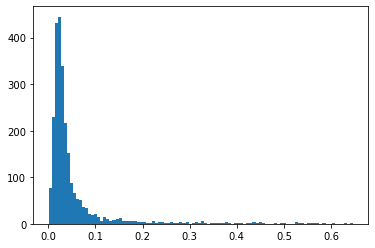

In [3]:
G = NSWClassifier()

N = 4000
values = []
for i in range(N):
    p = np.array([random.random(), random.random()])
    cls = 1 if vector_norm(p - np.array([.5, .5])) < 0.4 else 0
    if random.random() > .97: cls = 1 - cls
    values.append((p, cls))

G.build_navigable_graph(values, attempts=10)

rich_cut = sorted([(e, G.dist(G.nodes[e[0]].value, G.nodes[e[1]].value)) for e in G.cut], key=lambda v: v[1])
lengths = [e[1] for e in rich_cut]
plt.hist(lengths, bins=100)
plt.show()

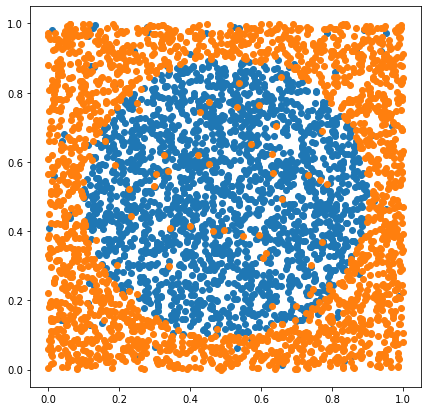

In [4]:
pos, neg = np.array([v[0] for v in values if v[1] == 1]), np.array([v[0] for v in values if v[1] == 0])
plt.figure(figsize=(7, 7))
plt.scatter(pos[:, 0], pos[:, 1])
plt.scatter(neg[:, 0], neg[:, 1])
plt.show()

In [5]:
smaller_cut = rich_cut[:1400]
print(smaller_cut[-1])

((423, 98), 0.030493615988032987)


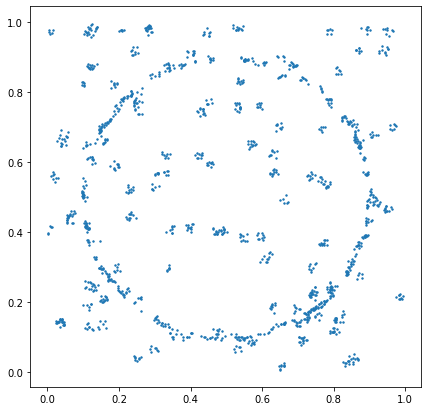

In [6]:
pts = np.array([(G.nodes[x[0]].value + G.nodes[x[1]].value) / 2 for x in [e[0] for e in smaller_cut]])
plt.figure(figsize=(7, 7))
plt.scatter(pts[:, 0], pts[:, 1], s=2)
plt.show()

In [7]:
a = range(360)
cx = [.5 + np.sin(np.pi * i/ 180) * .4 for i in a]
cy = [.5 + np.cos(np.pi * i/ 180) * .4 for i in a]

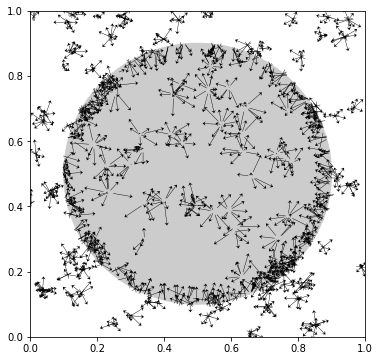

In [8]:
vecs = np.array([(G.nodes[x[0]].value - G.nodes[x[1]].value) * (G.nodes[x[0]]._class - G.nodes[x[1]]._class) for x in [e[0] for e in smaller_cut]])
plt.figure(figsize=(6, 6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.fill(cx, cy, color='#CCCCCC')
plt.quiver(pts[:, 0], pts[:, 1], vecs[:, 0], vecs[:, 1], width=.0013, scale=.5, headlength=7, headwidth=10, zorder=2)
plt.show()

In [9]:
def wilson(G, cut):
    cutset = set([r[0][0] for r in cut] + [r[0][1] for r in cut])
    local_cuts = dict((key, []) for key in cutset)
    for e in cut:
        local_cuts[e[0][0]].append(e)
        local_cuts[e[0][1]].append(e)

    clean_cut = set(cut)
    for k, lst in local_cuts.items():
        if len(lst) <= 4: # dim * 3 // 2
            continue
        for e in lst:
            if e in clean_cut: 
                clean_cut.remove(e)
    return list(clean_cut)

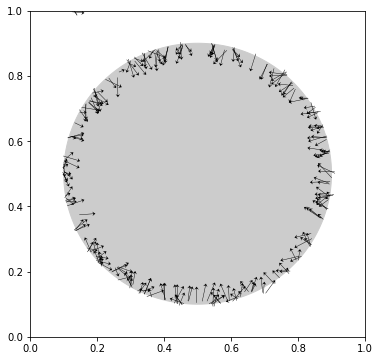

In [10]:
clean_cut = wilson(G, smaller_cut)
pts = np.array([(G.nodes[x[0]].value + G.nodes[x[1]].value) / 2 for x in [e[0] for e in clean_cut]])
vecs = np.array([(G.nodes[x[0]].value - G.nodes[x[1]].value) * (G.nodes[x[0]]._class - G.nodes[x[1]]._class) for x in [e[0] for e in clean_cut]])
plt.figure(figsize=(6, 6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.fill(cx, cy, color='#CCCCCC')
plt.quiver(pts[:, 0], pts[:, 1], vecs[:, 0], vecs[:, 1], width=.0013, scale=.5, headlength=7, headwidth=10, zorder=2)
plt.show()

get_grad_field_function: Edge index is prepared.


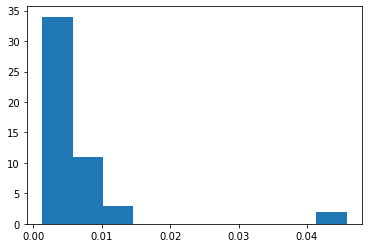

0.006530115912089024 0.0041149551076564055
<class 'numpy.ndarray'>
field


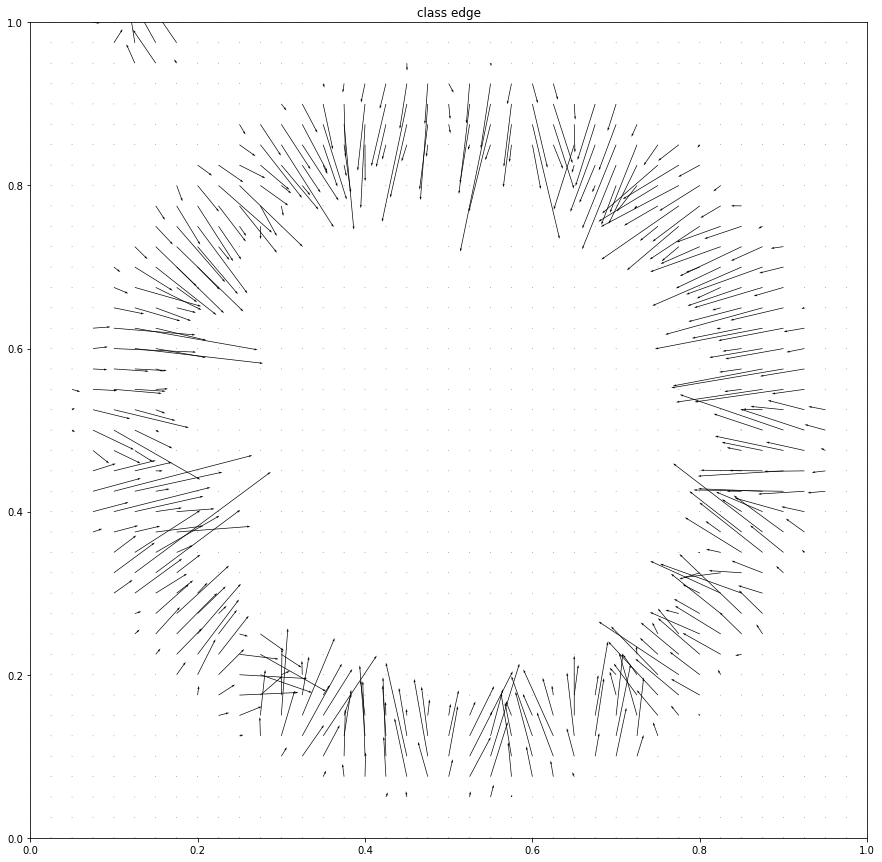

Computed in 12.8234s


In [11]:
import time
f = rbf.get_grad_field_function(G, clean_cut)

# avg_dist
dists = []
for i in range(50):
    n0 = random.choice(clean_cut)
    p0 = (G.nodes[n0[0][0]].value + G.nodes[n0[0][1]].value) / 2
    sd = []
    for n1 in clean_cut:
        if n0 == n1:
            continue
        p1 = (G.nodes[n1[0][0]].value + G.nodes[n1[0][1]].value) / 2
        d = vector_norm(p1 - p0)
        sd.append(d)
    dists.append(min(sd))

plt.hist(dists)
plt.show()
dists.sort()
print(sum(dists) / len(dists), dists[len(dists) // 2])
avg_shortest = sum(dists) / len(dists)
mid_shortest = dists[len(dists) // 2]
start = time.perf_counter()
plot_potential(0., 1., f, avg_shortest * 8, 41)
end = time.perf_counter()

print(f"Computed in {end - start:.4f}s")

In [12]:
support = []
for i in range(50):
    n = random.choice(G.nodes)
    support.append((n.value, n._class))

In [13]:
from nsw.cut_classifier import CutClassifier
cclf = CutClassifier(G, smaller_cut)
clf = cclf.classifier

Graph initialized with cut (1400).
Wilson: Data shape 2
Clean cut (254).
Shortest dist estimated (0.0041).
Support with 400 nodes is created.
Data dimensionality detected is 2. regularity = 6
	10.00% of graph construction
	20.00% of graph construction
	30.00% of graph construction
	40.00% of graph construction
	50.00% of graph construction
	60.00% of graph construction
	70.00% of graph construction
	80.00% of graph construction
	90.00% of graph construction
Support graph is built.
get_grad_field_function: Edge index is prepared.
Classifier function is ready.


<class 'float'>
flat


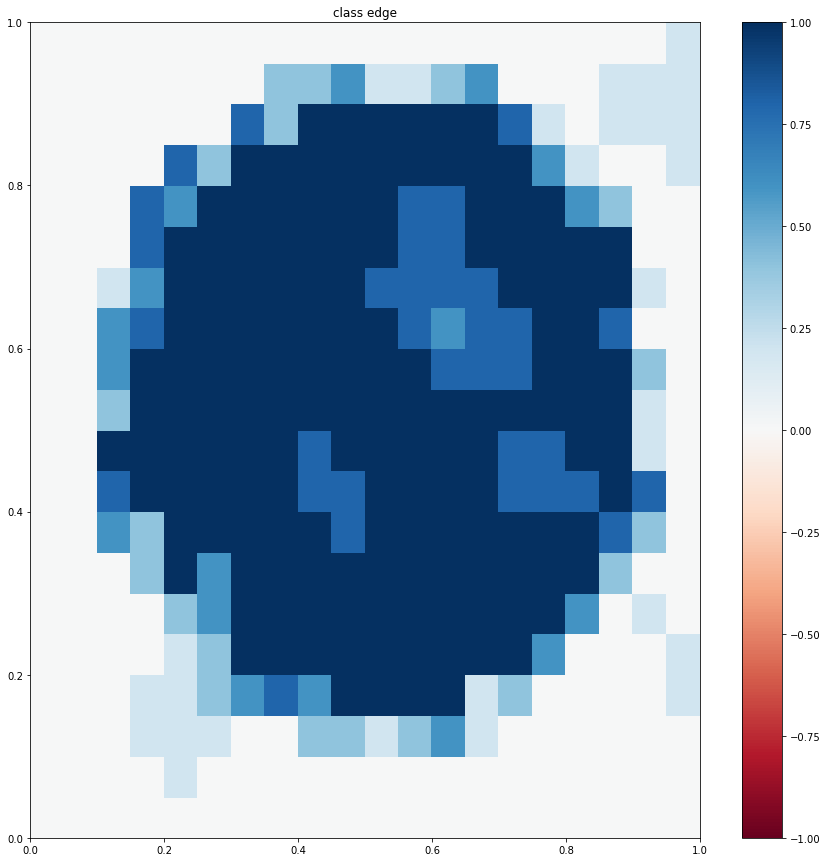

In [14]:
plot_potential(0., 1., clf, 8, 21)

{60: 0, 334: 0, 244: 0, 262: 0, 280: 0}
{55: 0, 165: 0, 134: 0, 216: 0, 317: 0}
{190: 0, 102: 0, 217: 0, 265: 0, 214: 0}
{355: -1, 362: -1, 387: -1, 331: -1, 221: -1}
{3: 0, 187: 0, 293: 1, 330: 0, 68: 0}
{185: 1, 365: -1, 386: 1, 264: 0, 201: 0}
{232: 1, 316: -1, 40: -1, 258: -1, 235: 1}


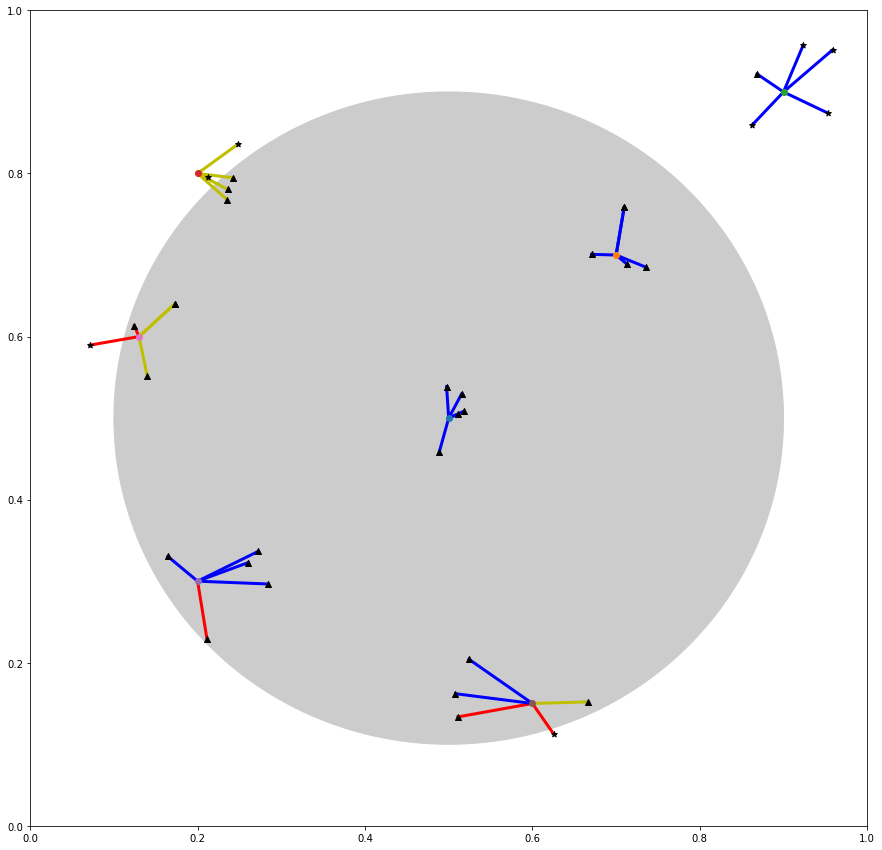

In [38]:
plt.figure(figsize=(15, 15))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.fill(cx, cy, color='#CCCCCC')

def draw(clf, x, monitor):
    plt.scatter([x[0]], [x[1]], marker="o", zorder=2)
    print(monitor)
    for n in monitor:
        v, c = clf.support_nsw.nodes[n].value, clf.support_nsw.nodes[n]._class
        plt.scatter([v[0]], [v[1]], marker="*" if c == 0 else "^", zorder=2, color='k')
        if monitor[n] == 0:
            plt.plot([x[0], v[0]], [x[1], v[1]], color='b', linewidth=3, zorder=1)
        elif monitor[n] == 1:
            plt.plot([x[0], v[0]], [x[1], v[1]], color='r', linewidth=3, zorder=1)
        else:
            plt.plot([x[0], v[0]], [x[1], v[1]], color='y', linewidth=3, zorder=1)



clf(np.array([.5, .5]), R=8, callback=draw)
clf(np.array([.7, .7]), R=8, callback=draw)
clf(np.array([.9, .9]), R=8, callback=draw)
clf(np.array([.2, .8]), R=8, callback=draw)
clf(np.array([.2, .3]), R=8, callback=draw)
clf(np.array([.6, .15]), R=8, callback=draw)
clf(np.array([.13, .6]), R=8, callback=draw)
plt.show()

In [39]:
N = 200
test = []
for i in range(N):
    p = np.array([random.random(), random.random()])
    cls = 1 if vector_norm(p - np.array([.5, .5])) < 0.4 else 0
    test.append((p, cls))
    
print("cutsize,small,R,k,m,acc")
for cutsize in [100, 500, 1000, 2000, 4000][::-1]:
    cclf = CutClassifier(G, rich_cut[:cutsize], verbose=False)
    clf = cclf.classifier
    for small in [0.0001, 0.005, 0.1]:
        for R in [16, 8, 4, 2, 1]:
            for k in [1, 5, 9, 13]:
                for m in [8, 16, 32]:
                    true = 0
                    for t in test:
                        pc = clf(t[0], R=R, small=small, closest=k, M=m)
                        if int(pc > .5) == t[1]: true += 1

                    print(f"{cutsize},{small},{R},{k},{m},{true / len(test):.3f}")

cutsize,small,R,k,m,acc
Graph initialized with cut (2500).
Wilson: Data shape 2
Clean cut (122).
Shortest dist estimated (0.0071).
Support with 400 nodes is created.
Support graph is built.
get_grad_field_function: Edge index is prepared.
Classifier function is ready.
4000,0.0001,16,1,8,0.720
4000,0.0001,16,1,16,0.715
4000,0.0001,16,1,32,0.705
4000,0.0001,16,5,8,0.755
4000,0.0001,16,5,16,0.740
4000,0.0001,16,5,32,0.735
4000,0.0001,16,9,8,0.745
4000,0.0001,16,9,16,0.730
4000,0.0001,16,9,32,0.730
4000,0.0001,16,13,8,0.765
4000,0.0001,16,13,16,0.765
4000,0.0001,16,13,32,0.760
4000,0.0001,8,1,8,0.855
4000,0.0001,8,1,16,0.845
4000,0.0001,8,1,32,0.840
4000,0.0001,8,5,8,0.895
4000,0.0001,8,5,16,0.895
4000,0.0001,8,5,32,0.895
4000,0.0001,8,9,8,0.900
4000,0.0001,8,9,16,0.880
4000,0.0001,8,9,32,0.875
4000,0.0001,8,13,8,0.920
4000,0.0001,8,13,16,0.890
4000,0.0001,8,13,32,0.890
4000,0.0001,4,1,8,0.915
4000,0.0001,4,1,16,0.920
4000,0.0001,4,1,32,0.920
4000,0.0001,4,5,8,0.955
4000,0.0001,4,5,16,0.95